In [58]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import sys
import time
import math
import matplotlib
import matplotlib.pyplot as plt
from contextlib import contextmanager

from IPython.display import display

pd.options.display.max_columns = None

import warnings


from tqdm import tqdm
# library options
%matplotlib inline
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

# contectmanager
@contextmanager
def change_dir(path):
    oldpwd=os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

In [19]:
# RAW DATASETS

df1 = pd.read_parquet('data/df1.parquet', engine='pyarrow')
df2 = pd.read_parquet('data/df2.parquet', engine='pyarrow')


In [37]:
df2['account_id'].value_counts()

199447451    121
182093960    105
98491143     104
167529481     97
113958422     89
            ... 
94707422       1
94694483       1
94673913       1
94666344       1
99987522       1
Name: account_id, Length: 190356, dtype: int64

In [66]:
idx = df2['account_id'].unique()
test = df2[df2['account_id'] == '199447451'].drop(['account_id'], axis=1)
#test.rename(columns={"event_time": "ds", "amount": "y"}, inplace = True)
test.sort_values(['event_time'],ascending = True, inplace = True)
min(test['expbalance'])

113.0

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


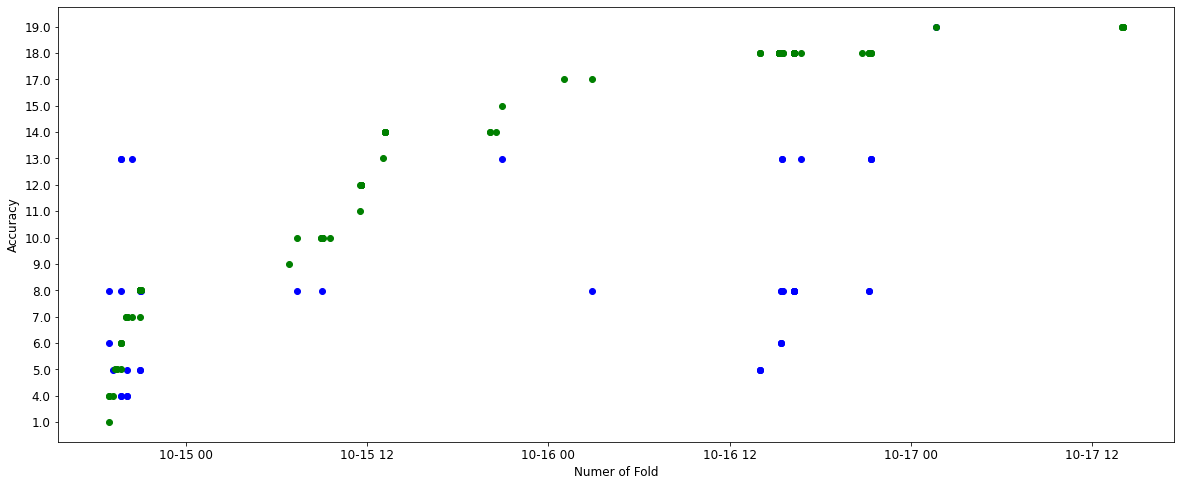

In [63]:
plt.figure(figsize=(20, 8))
plt.scatter(test['event_time'],test['amount'], color = 'blue', label = 'amount')
#plt.scatter(test['event_time'],test['expbalance'], color = 'orange', label = 'expbalance')
plt.scatter(test['event_time'],test['level'], color = 'green', label = 'level')

#plt.title('Results KFOLD Cross-Validation')
plt.ylabel('Accuracy')
plt.xlabel("Numer of Fold")
#plt.legend()
#plt.grid()
#plt.savefig('results/DNN_KFold_Accuracy_withoutTA.png')
plt.xticks(rotation = 0)
plt.rcParams.update({'font.size': 12})

# Transformation in 72h time scale

In [3]:
##### INITALIZE DF
##### INITALIZE DF
##### INITALIZE DF
#data_name = "test" ### ADAPT FOR DATASET ("train" or "test")

# # intialize df1 and df2
# if data_name == "train":
#     df1 = df1_train
#     df2 = df2_train

# if data_name == "test":
#     df1 = df1_test
#     df2 = df2_test


# setting accound_id as index of dataset 1
df1 = df1.set_index("account_id", drop = True)

# drop rows with nan value in "event_time_seconds"
df2 = df2.dropna(subset = ["event_time"])

# sorting dataset 2 by account_id (first) and event_time (second)
df2 = df2.sort_values(["account_id","event_time"], ascending = (True, True))


In [4]:
# Transformation in 72h scale

# creating a new column in df2
df2["event_time_seconds"] = 0


account_ids = df2["account_id"].unique()

index = 0
failure = 0

for i in tqdm(range(len(account_ids))):
    
    account_id = account_ids[i]
    n_purchases = len(df2[df2["account_id"] == account_id])
    
    try:
        seconds_to_first_purchase = df1.loc[account_ids[i]]["time_to_first_purchase"]
        failure = 0
    except:
        failure = 1
    
    
    for j in range(0,n_purchases):

        if failure == 0:
            if j == 0:
                timestamp_first_purchase = df2.iloc[index]["event_time"]

                df2["event_time_seconds"].iloc[index] = seconds_to_first_purchase
                
            
            else:
                timestamp_j_purchase = df2.iloc[index]["event_time"]
                seconds_to_j_purchase = (timestamp_j_purchase - timestamp_first_purchase).total_seconds() + seconds_to_first_purchase
                df2["event_time_seconds"].iloc[index] = seconds_to_j_purchase
        
        else:
            df2["event_time_seconds"].iloc[index] = -1
        
        index += 1

100%|██████████| 190356/190356 [1:24:21<00:00, 37.61it/s]


In [5]:
df2 = df2[df2['event_time_seconds'] != -1]

In [6]:
df2.to_parquet("data/df2_72h.parquet")

In [7]:
df2

,account_id,event_time,amount,expbalance,level,event_time_seconds
36888,100000423,2021-03-14 01:46:07.476,9.99,16575.0,7.0,58465.906
146769,100001374,2021-03-14 21:19:21.456,2.99,35.0,6.0,101128.285
344735,100001463,2021-03-13 11:10:35.336,0.99,211.0,3.0,5107.187
255460,100001654,2021-03-13 18:53:08.358,2.99,161.0,1.0,5759.386
255459,100001654,2021-03-13 20:24:56.872,2.00,22796.0,5.0,11267.900
...,...,...,...,...,...,...
326956,99996154,2021-03-13 17:14:27.808,2.99,127.0,1.0,3355.890
273499,99997303,2021-03-14 20:24:00.165,1.99,2993.0,7.0,127780.295
273500,99998783,2021-03-15 15:08:05.300,1.99,43004.0,15.0,194162.919
182903,99999273,2021-03-13 10:01:01.622,2.99,2573.0,1.0,2609.840


# Classifying in day1, day2, day3 (approach 1)

In [8]:
##### INITALIZE DF
##### INITALIZE DF
##### INITALIZE DF

# load dataset_2 with 72h scale
df2_loaded = pd.read_parquet("data/df2_72h.parquet")

# drop rows with NaN in "event_time_seconds"
df2_loaded = df2_loaded.dropna(subset = ["event_time_seconds"])

# indicates whether a purchase was made on that day (yes: 1, no: 0)
df2_loaded["day_1"] = 0
df2_loaded["day_2"] = 0
df2_loaded["day_3"] = 0

b1 = 24*3600
b2 = 48*3600
b3 = 72*3600

for i in range(len(df2_loaded)):
    t = df2_loaded["event_time_seconds"].iloc[i]
    
    if 0 <= t < b1:
        df2_loaded["day_1"].iloc[i] = 1
        
    if b1 <= t < b2:
        df2_loaded["day_2"].iloc[i] = 1
        
    if b2 <= t < b3:
        df2_loaded["day_3"].iloc[i] = 1


In [9]:
df2_loaded["account_id"].nunique()

139938

In [10]:
df2_loaded

,account_id,event_time,amount,expbalance,level,event_time_seconds,day_1,day_2,day_3
36888,100000423,2021-03-14 01:46:07.476,9.99,16575.0,7.0,58465.906,1,0,0
146769,100001374,2021-03-14 21:19:21.456,2.99,35.0,6.0,101128.285,0,1,0
344735,100001463,2021-03-13 11:10:35.336,0.99,211.0,3.0,5107.187,1,0,0
255460,100001654,2021-03-13 18:53:08.358,2.99,161.0,1.0,5759.386,1,0,0
255459,100001654,2021-03-13 20:24:56.872,2.00,22796.0,5.0,11267.900,1,0,0
...,...,...,...,...,...,...,...,...,...
326956,99996154,2021-03-13 17:14:27.808,2.99,127.0,1.0,3355.890,1,0,0
273499,99997303,2021-03-14 20:24:00.165,1.99,2993.0,7.0,127780.295,0,1,0
273500,99998783,2021-03-15 15:08:05.300,1.99,43004.0,15.0,194162.919,0,0,1
182903,99999273,2021-03-13 10:01:01.622,2.99,2573.0,1.0,2609.840,1,0,0


In [11]:
account_ids = df2_loaded["account_id"].unique()

df2_modified = pd.DataFrame(index=[account_ids])

df2_loaded = df2_loaded.sort_values(["account_id","event_time"], ascending = (True, True))

# new dataframe
df2_modified = pd.DataFrame(index=[account_ids])

# frequency 
df2_modified["n_day_1"] = 0
df2_modified["n_day_2"] = 0
df2_modified["n_day_3"] = 0

# total amount
df2_modified["sum_day_1"] = 0
df2_modified["sum_day_2"] = 0
df2_modified["sum_day_3"] = 0

index = 0 
for i in range(len(account_ids)):
    
    account_id = account_ids[i]
    n_purchases = len(df2_loaded[df2_loaded["account_id"] == account_id])
    

    for j in range(0,n_purchases):
        
        amount = df2_loaded.iloc[index]["amount"]
        
        if df2_loaded.iloc[index]["day_1"] == 1:
            df2_modified["n_day_1"].loc[account_id] += 1
            df2_modified["sum_day_1"].loc[account_id] += amount 
            
        if df2_loaded.iloc[index]["day_2"] == 1:
            df2_modified["n_day_2"].loc[account_id] += 1
            df2_modified["sum_day_2"].loc[account_id] += amount 

        if df2_loaded.iloc[index]["day_3"] == 1:
            df2_modified["n_day_3"].loc[account_id] += 1
            df2_modified["sum_day_3"].loc[account_id] += amount 
        
        
        
        index += 1
        

In [12]:
# SAVE AS PARQUET

df2_modified.to_parquet("data/df2_123.parquet")


In [13]:
df2_123 = df2_modified
df2_modified

,n_day_1,n_day_2,n_day_3,sum_day_1,sum_day_2,sum_day_3
100000423,1,0,0,9.99,0.00,0.00
100001374,0,1,0,0.00,2.99,0.00
100001463,1,0,0,0.99,0.00,0.00
100001654,3,0,0,6.99,0.00,0.00
100003092,1,0,0,0.99,0.00,0.00
...,...,...,...,...,...,...
99996154,1,0,0,2.99,0.00,0.00
99997303,0,1,0,0.00,1.99,0.00
99998783,0,0,1,0.00,0.00,1.99
99999273,1,0,0,2.99,0.00,0.00


# Clumpiness (approach 2)

In [9]:
# load dataset_2 with 72h scale
df2_loaded = pd.read_parquet("data/df2_72h.parquet")

# drop rows with NaN in "event_time_seconds"
df2_loaded = df2_loaded.dropna(subset = ["event_time_seconds"])

df2_loaded['index1'] = df2_loaded.index

# round the time and convert to ingeger
df2_loaded["event_time_minutes"] = pd.to_numeric((df2_loaded["event_time_seconds"] / 60).round(),downcast="integer")
df2_loaded["event_time_hours"] = pd.to_numeric((df2_loaded["event_time_seconds"] / 3600).round(),downcast="integer")
df2_loaded["event_time_seconds"] = pd.to_numeric(df2_loaded["event_time_seconds"].round(),downcast="integer")
df2_loaded['index1'] = df2_loaded.index

df2_loaded

,account_id,event_time,amount,expbalance,level,event_time_seconds,index1,event_time_minutes,event_time_hours
36888,100000423,2021-03-14 01:46:07.476,9.99,16575.0,7.0,58466,36888,974,16
146769,100001374,2021-03-14 21:19:21.456,2.99,35.0,6.0,101128,146769,1685,28
344735,100001463,2021-03-13 11:10:35.336,0.99,211.0,3.0,5107,344735,85,1
255460,100001654,2021-03-13 18:53:08.358,2.99,161.0,1.0,5759,255460,96,2
255459,100001654,2021-03-13 20:24:56.872,2.00,22796.0,5.0,11268,255459,188,3
...,...,...,...,...,...,...,...,...,...
326956,99996154,2021-03-13 17:14:27.808,2.99,127.0,1.0,3356,326956,56,1
273499,99997303,2021-03-14 20:24:00.165,1.99,2993.0,7.0,127780,273499,2130,35
273500,99998783,2021-03-15 15:08:05.300,1.99,43004.0,15.0,194163,273500,3236,54
182903,99999273,2021-03-13 10:01:01.622,2.99,2573.0,1.0,2610,182903,43,1


In [10]:
# Bundle duplicates (same account_id AND event_time_seconds) to just ONE purchase

# dataframe containing all duplicates with regard to account_id AND event_time_seconds
duplicates = df2_loaded[df2_loaded.duplicated(subset=['account_id','event_time_seconds'], keep = False)]
duplicates = duplicates.sort_values(["account_id","event_time_seconds"])

account_ids = duplicates["account_id"].unique() # unique account_ids in duplicate data frame

index = 0 
for account_id in account_ids:
    #print("--------------------")
    #print("account_id", account_id)
    
    n_duplicates = len(duplicates[duplicates["account_id"] == account_id])
    
    #print("n_duplicates",n_duplicates)
    
    #n_double_duplicates = duplicates[duplicates["account_id"] == "103133212"]["event_time_seconds"].nunique()

    for j in range(n_duplicates):
        
        t = duplicates.iloc[index]["event_time_seconds"]
        
        if j == 0:
            first_index = duplicates.iloc[index]["index1"]
            first_time = t
            index +=1
            #print("first_id", first_index)
            continue
            
        elif t == first_time:
            index_remain = duplicates.iloc[index]["index1"]
            df2_loaded["amount"].loc[first_index] += df2_loaded["amount"].loc[index_remain]
            df2_loaded = df2_loaded.drop(duplicates.iloc[index]["index1"])
            index +=1
            continue
            
        else:
            first_index = duplicates.iloc[index]["index1"]
            first_time = t
            index +=1
            continue

In [17]:
df2_loaded = df2_loaded.sort_values(["account_id","event_time"], ascending = (True, True))
account_idx = df2_loaded["account_id"].unique()

df2_loaded[df2_loaded['account_id'] == account_idx[100]]['level']

273510    8.0
Name: level, dtype: object

In [16]:
# creating new DataFrame for saving gradient factors
df2_loaded = df2_loaded.sort_values(["account_id","event_time"], ascending = (True, True))
account_idx = df2_loaded["account_id"].unique()
df2_gradient = pd.DataFrame(index=[account_idx])

# purchase frequency of an account_id
n_purchases = [len(df2_loaded[df2_loaded["account_id"] == account_id]) for account_id in tqdm((account_idx))]

df2_gradient["frequency"] = n_purchases
df2_gradient["gradient"] = 0

for account_id in account_idx:
    n = df2_gradient.loc[account_id]["frequency"].values[0]
    
    if n > 1:
        first_lvl = df2_loaded[df2_loaded['account_id'] == account_id]['level'].values[0]
        last_lvl = df2_loaded[df2_loaded['account_id'] == account_id]['level'].values[-1]
        first_time_sec = df2_loaded[df2_loaded['account_id'] == account_id]['event_time_seconds'].values[0]
        last_time_sec = df2_loaded[df2_loaded['account_id'] == account_id]['event_time_seconds'].values[-1]
        
        try:
            gradient = (float(last_lvl) - float(first_lvl)) / (float(last_time_sec) - float(first_time_sec))
        except:
            gradient = 0
            
        df2_gradient.loc[[account_id],["gradient"]] = gradient * 100
    else:
        df2_gradient.loc[[account_id],["gradient"]] = 0
        
        
df2_gradient["gradient"] = df2_gradient["gradient"].apply(lambda x: 0 if x < 0 else x)
df2_gradient

100%|██████████| 139938/139938 [41:29<00:00, 56.22it/s]


,frequency,gradient
100000423,1,0.000000
100001374,1,0.000000
100001463,1,0.000000
100001654,3,0.066611
100003092,1,0.000000
...,...,...
99996154,1,0.000000
99997303,1,0.000000
99998783,1,0.000000
99999273,1,0.000000


In [23]:
df2_gradient[df2_gradient["gradient"] > 0]

,frequency,gradient
100001654,3,0.066611
100003444,4,0.011141
100009582,2,0.002571
100010452,3,0.004342
100010812,6,0.008499
...,...,...
99993134,4,0.023842
99993592,7,0.006593
99994182,3,0.223464
99995053,2,0.001036


In [24]:
# creating new DataFrame for saving clumpiness factors
account_ids = df2_loaded["account_id"].unique()
df2_clump = pd.DataFrame(index=[account_ids])


# purchase frequency of an account_id
account_ids = df2_loaded["account_id"].unique()
n_purchases = [len(df2_loaded[df2_loaded["account_id"] == account_id]) for account_id in tqdm((account_ids))]

df2_clump["frequency"] = n_purchases
df2_clump["clumpiness"] = 0

df2_clump

100%|██████████| 139938/139938 [40:34<00:00, 57.48it/s]


,frequency,clumpiness
100000423,1,0
100001374,1,0
100001463,1,0
100001654,3,0
100003092,1,0
...,...,...
99996154,1,0
99997303,1,0
99998783,1,0
99999273,1,0


In [25]:
# Calculating IETs / x_i values

N = 72*3600 # seconds

index = 0

for account_id in account_ids:
    n = df2_clump.loc[account_id]["frequency"].values[0] # number of purchases the account_id did
    x = [] # safe x values of account_id in list
    #print("account_id-------------------", account_id)
    
    for i in range(0, n+1):
        
        #print("index", index)
        
        if i == 0:
            t_i = df2_loaded.iloc[index]["event_time_seconds"] # current purchase of the account_id
            x_i = t_i
            x.append(x_i)
            index += 1
            continue

        if i >= 1 and i < n:
            t_i = df2_loaded.iloc[index]["event_time_seconds"] # current purchase of the account_id
            t_j = df2_loaded.iloc[index-1]["event_time_seconds"] # previous purchase of the account_id
            x_i = t_i - t_j
            x.append(x_i)
            index += 1
            continue
            
        if i == n:
            t_n = df2_loaded.iloc[index-1]["event_time_seconds"] # last purchase of the account_id
            x_i = N - t_n
            x.append(x_i)
            continue
        
        #print(i, "-----xi:", x_i)
    
    x = np.array(x) / (N+1)
    #print(x)
    c = 1 + sum([x[i]*math.log(x[i],10) for i in range(0,n+1)]) / math.log(n+1, 10)
    df2_clump["clumpiness"].loc[account_id] = c
    
    
    

In [26]:
df2_clump.loc[account_id]["frequency"].values[0]

1

In [27]:
# SAVE AS PARQUET
df2_gradient.drop(["frequency"], axis = 1, inplace = True)
df2_gradient["gradient"] = df2_gradient["gradient"].apply(lambda x: 0 if x < 0 else x)
merged = df2_clump.join(df2_gradient, how = 'inner')
merged

,frequency,clumpiness,gradient
100000423,1,0.229801,0.000000
100001374,1,0.035099,0.000000
100001463,1,0.860226,0.000000
100001654,3,0.839317,0.066611
100003092,1,0.858966,0.000000
...,...,...,...
99996154,1,0.900241,0.000000
99997303,1,0.000141,0.000000
99998783,1,0.187273,0.000000
99999273,1,0.918742,0.000000


In [28]:
# add gradient list
df2_clump.to_parquet("data/df2_clump.parquet")
merged.to_parquet("data/df2_clump_gradient.parquet")

In [29]:
df2_clump

,frequency,clumpiness
100000423,1,0.229801
100001374,1,0.035099
100001463,1,0.860226
100001654,3,0.839317
100003092,1,0.858966
...,...,...
99996154,1,0.900241
99997303,1,0.000141
99998783,1,0.187273
99999273,1,0.918742


In [30]:
print(df2_123.shape)
print(df2_clump.shape)

(139938, 6)
(139938, 2)


In [33]:
max(merged['gradient'])

400.0